✅ Extracted: co2_emissions.zip
✅ Extracted: gdp_per_capita.zip
✅ Extracted: population.zip
✅ Extracted: renewable_energy.zip
✅ Final cleaned dataset saved as: final_cleaned_esg_data.csv
              year  co2_emissions  gdp_per_capita    population  \
count   447.000000     447.000000    4.470000e+02  4.470000e+02   
mean   2005.606264      26.745353    1.267613e+12  3.952766e+07   
std       9.235424      24.216678    3.817146e+12  8.707083e+07   
min    1990.000000       7.701565    9.645570e+07  1.598900e+04   
25%    1998.000000      16.274829    1.044933e+10  5.848275e+05   
50%    2006.000000      19.225705    7.749753e+10  2.434662e+06   
75%    2014.000000      26.328147    5.188799e+11  2.420428e+07   
max    2022.000000     202.865184    2.329113e+13  3.696707e+08   

       renewable_energy  
count        447.000000  
mean           3.565791  
std            6.021573  
min            0.000000  
25%            0.000000  
50%            0.100000  
75%            5.850000  
ma

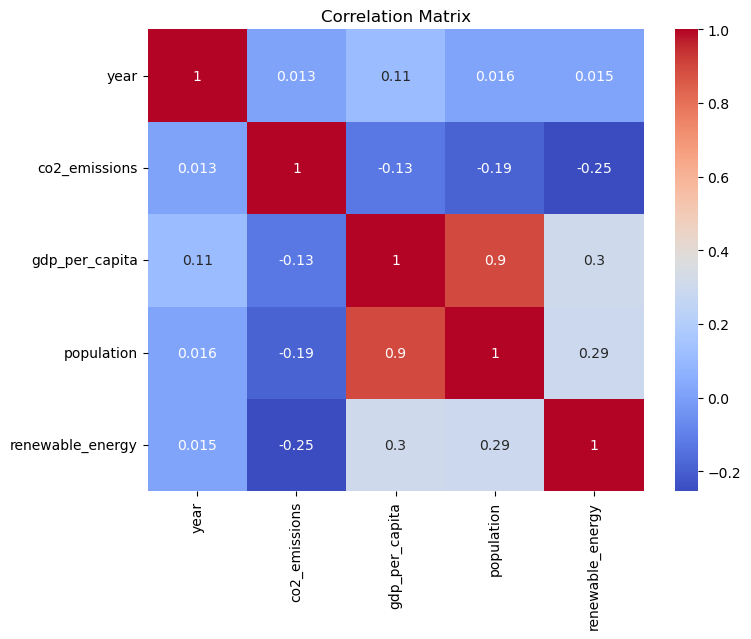

In [13]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

zip_dir = r"C:\ESG_Risk_Dashboard3\Data"

def extract_all_zips(path):
    for f in os.listdir(path):
        if f.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(path, f)) as z:
                z.extractall(os.path.join(path, f[:-4]))
            print(f"✅ Extracted: {f}")

def load_and_clean(folder, val):
    fp = os.path.join(zip_dir, folder)
    csv = next(f for f in os.listdir(fp) if f.endswith('.csv') and "Metadata" not in f)
    df = pd.read_csv(os.path.join(fp, csv), skiprows=4)
    df = df.rename(columns={"Country Name": "country", "Country Code": "code"})
    df = df.melt(id_vars=["country", "code"], var_name="year", value_name=val)
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df[val] = pd.to_numeric(df[val], errors='coerce')
    return df.dropna()

def filter_top_countries(df, value_col, top_n=15):
    latest = df['year'].max()
    return df.loc[df['year'] == latest]\
             .nlargest(top_n, value_col)['country']\
             .tolist()

def main():
    extract_all_zips(zip_dir)
    co2 = load_and_clean("co2_emissions", "co2_emissions")
    gdp = load_and_clean("gdp_per_capita", "gdp_per_capita")
    pop = load_and_clean("population", "population")
    renew = load_and_clean("renewable_energy", "renewable_energy")

    top_countries = filter_top_countries(co2, 'co2_emissions')

    for df in (co2, gdp, pop, renew):
        df.query("country in @top_countries", inplace=True)

    df = co2.merge(gdp, on=["country", "code", "year"])\
            .merge(pop, on=["country", "code", "year"])\
            .merge(renew, on=["country", "code", "year"])\
            .dropna()

    df.to_csv("final_cleaned_esg_data.csv", index=False)
    print("✅ Final cleaned dataset saved as: final_cleaned_esg_data.csv")
    print(df.describe())

    plt.figure(figsize=(8,6))
    sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()

if __name__ == "__main__":
    main()
